In [1]:
%matplotlib inline

import numpy as np, pandas as pd, pickle, requests, pprint, json
import matplotlib.pyplot as plt, mpl_toolkits.mplot3d.axes3d as axes3d, matplotlib as mpl
from scipy import stats
from bs4 import BeautifulSoup as bs
from astropy.time import Time
mpl.rcParams['font.family'] = 'Consolas'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

### Read nulling data found in appendix of [2019JApA...40...42K](https://ui.adsabs.harvard.edu/#abs/2019JApA...40...42K/abstract)
Because the data table in the publication is only accessible in the .PDF of the article itself, I manually copied/entered/repaired the ~150 or so entries into a dedicated .CSV file, which is stored locally. This code then parses the errors reported in the table (given in terms of either maximums, minimums, or uncertainties, depending on the datapoint) and converts them into standardized ranges of possible values. 

In [2]:
nullstats = pd.read_csv("pulsarstats.csv",usecols=[i+1 for i in range(6)])
nullstats["NF"] = [(entry.split("±")[0] if "±" in entry else entry.split("≤")[1] if "≤" in entry else entry.split("≥")[1] if "≥" in entry else entry) for entry in nullstats["NF (%)"]]
nullstats["NF"] = nullstats["NF"].astype(float)
nullstats["NF_e"] = [((entry.split("±")[1],entry.split("±")[1]) if "±" in entry else (entry.split("≤")[1],0) if "≤" in entry else (0,100-float(entry.split("≥")[1])) if "≥" in entry else (0,0)) for entry in nullstats["NF (%)"]]
nullstats["NF_e"] = [[float(negative),float(positive)] for (negative,positive) in nullstats["NF_e"]]
nullstats.drop(["NF (%)"],axis=1,inplace=True)

### Scrape and compile the [ATNF pulsar catalog](https://www.atnf.csiro.au/research/pulsar/psrcat/) into a workable table
ATNF maintains a catalog of just about every recorded pulsar along with many of their physical parameters. This allows analysis of other variables beyond just period and magnetic field. The table is presented in plain text, so some fairly intenseive parsing has to take place to clean it up and filter the relevant information into a usable dataframe.

In [3]:
ATNFtable = requests.get("https://www.atnf.csiro.au/people/pulsar/psrcat/proc_form.php?version=1.63&table_top.x=27&table_top.y=31&Name=Name&JName=JName&GL=GL&GB=GB&RaJD=RaJD&DecJD=DecJD&P0=P0&P1=P1&DM=DM&Dist=Dist&ZZ=ZZ&XX=XX&YY=YY&Type=Type&NGlt=NGlt&Age=Age&Bsurf=Bsurf&Edot=Edot&startUserDefined=true&c1_val=&c2_val=&c3_val=&c4_val=&sort_attr=jname&sort_order=asc&condition=&pulsar_names=&ephemeris=short&coords_unit=raj%2Fdecj&radius=&coords_1=&coords_2=&style=Long+with+last+digit+error&no_value=*&fsize=3&x_axis=&x_scale=linear&y_axis=&y_scale=linear&state=query").content
lines = bs(ATNFtable).find('pre').get_text().split('\n')
data = [pulsar for pulsar in [line.split() for line in lines] if len(pulsar) > 1]

for pulsar in data[2:]:
    for i in [27,25,19,18,16,15,13,12,10,8,4,2]:
        del pulsar[i]

data[1] = [None,None]+data[1]

ATNF = pd.DataFrame(data[2:], columns=data[0])
numeric_cols=['#', 'Gl', 'Gb', 'RAJD', 'DECJD', 'P0', 'P1', 'DM', 'DIST', 'ZZ', 'XX', 'YY', 'NGLT', 'AGE', 'BSURF', 'EDOT']
ATNF[numeric_cols] = ATNF[numeric_cols].apply(pd.to_numeric, errors='coerce')
ATNF = ATNF.set_index('#').rename(columns={"PSR": "TYPE"}).dropna(subset=["P0","P1"])
ATNF.index.name = None
ATNF["RR"] = list(np.sqrt(ATNF.XX**2+ATNF.YY*2+ATNF.ZZ**2))

c:\users\caden gobat\appdata\local\programs\python\python36\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Cross-ref the nulling pulsars in the ATNF catalog to obtain all of their parameters
Match up entries in the two dataframes to create one that contains all the information on all of the pulsars on interest.

In [4]:
merged = pd.merge(ATNF,nullstats,left_on="PSRJ",right_on="J-Name").drop(["PSR name","J-Name","P (s)","B (G)"],axis=1)
display(merged)

,NAME,PSRJ,Gl,Gb,RAJD,DECJD,P0,P1,DM,DIST,...,YY,TYPE,NGLT,AGE,BSURF,EDOT,RR,References,NF,NF_e
0,B0031-07,J0034-0721,110.420,-69.815,8.536960,-7.364836,0.942951,4.082100e-16,10.92200,1.03,...,8.62,*,NaN,36600000.0,6.280000e+11,1.900000e+31,4.276658,Gajjar (2017),44.0,"[1.0, 1.0]"
1,B0045+33,J0048+3412,122.255,-28.666,12.142000,34.202000,1.217094,2.354540e-15,39.92200,4.50,...,10.61,*,NaN,8190000.0,1.710000e+12,5.200000e+31,6.086148,Redman and Rankin (2009),21.0,"[1.0, 1.0]"
2,B0148-06,J0151-0635,160.368,-65.004,27.844658,-6.584163,1.464665,4.425900e-16,25.66000,25.00,...,18.45,*,NaN,52400000.0,8.150000e+11,5.600000e+30,23.727160,Biggs (1992),5.0,"[5.0, 0.0]"
3,B0149-16,J0152-1637,179.306,-72.457,28.045225,-16.631567,0.832742,1.299202e-15,11.92577,0.92,...,8.78,*,NaN,10200000.0,1.050000e+12,8.900000e+31,4.281869,Vivekanand (1995),2.5,"[2.5, 0.0]"
4,B0301+19,J0304+1932,161.135,-33.270,46.137980,19.547600,1.387584,1.295235e-15,15.65677,0.74,...,9.09,*,NaN,17000000.0,1.360000e+12,1.900000e+31,4.288135,Rankin (1986),10.0,"[0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,B2315+21,J2317+2149,95.831,-36.075,349.491008,21.830005,1.444653,1.047047e-15,20.86959,1.96,...,8.66,*,NaN,21900000.0,1.240000e+12,1.400000e+31,4.597706,Weisberg et al. (1986),3.0,"[0.5, 0.5]"
143,B2319+60,J2321+6024,112.095,-0.566,350.480000,60.408500,2.256488,7.036890e-15,94.59100,2.70,...,9.52,*,NaN,5080000.0,4.030000e+12,2.400000e+31,5.029006,Gajjar (2017),29.0,"[1.0, 1.0]"
144,B2327-20,J2330-2005,49.394,-70.190,352.612020,-20.091560,1.643622,4.630380e-15,8.45600,0.86,...,8.31,*,NaN,5620000.0,2.790000e+12,4.100000e+31,4.162271,Biggs (1992),12.0,"[1.0, 1.0]"
145,J2346-0609,J2346-0609,83.798,-64.015,356.710408,-6.166639,1.181463,1.363050e-15,22.50400,3.70,...,8.32,*,NaN,13700000.0,1.280000e+12,3.300000e+31,5.506451,Basu et al. (2017),42.5,"[3.8, 3.8]"


### Traverse and record datafiles in [EPTA's EPN database](http://www.epta.eu.org/epndb/) of pulsar profiles
So far we have collected pulsar parameter data. This will get us information about the actual pulse profile. The EPN database does not have a workable search functionality, but by accessing the backend we can get at the content directly and index it ourselves. The function here crawls the filetree and finds all of the actual .JSON data files. Later these can be compiled by source as needed.

In [5]:
def get_jsons(jsonlist,parent="http://www.epta.eu.org/epndb/json/"): # pass the list to be modified and the active page link
    page = requests.get(parent).content # get the content of the current page
    childnames = [folder.get_text() for folder in bs(page).findAll('a')[5:]] # use BeautifulSoup to get a list of all the links
    for child in childnames: # for each link
        if child[-5:] == ".json": # if the link is an endpoint,
            jsonlist.append(parent+child) # add it to the list of file links
            print("", end=f"\r{child} registered."+" "*25)
        else:
            get_jsons(jsonlist,parent+child) # call the function again on the new child URL, with the current list


linksource = input("Enter the path/name of your local pickle file containing the list of links, or use 'epndb' to re-register all files from EPTA's server (this will take some time).\n")

if linksource == "epndb":
    epndb = [] # init list
    get_jsons(epndb) # pass the empty list to modify
    with open("epndb.pkl","wb") as picklewriter:
        pickle.dump(epndb,picklewriter)
else:
    with open(linksource,"rb") as savedpickle: # it is preferable not to have to run the webcrawler every time
        epndb = pickle.load(savedpickle) # once it has been run once, the list can be reloaded from a locally stored pickle dump

epndf = pd.DataFrame([line.split("/")[-3:] for line in epndb],columns=["Reference","Source","Filename"])

Enter the path/name of your local pickle file containing the list of links, or use 'epndb' to re-register all files from EPTA's server (this will take some time).
epndb.pkl


#### Create a dictionary of datafiles by source

In [6]:
epndict = {}

for pulsar,subsect in epndf.groupby("Source"):
    epndict[pulsar] = {}
    
    for reference,subsubsect in subsect.groupby("Reference"):
        epndict[pulsar].update({reference:list(subsubsect["Filename"])})

pprint.pprint(epndict)

{'J0006+1834': {'bkk+16': ['J0006+1834_HBA_census.0000_0000.ar.json'],
                'cn95': ['cn95.epn.json']},
 'J0014+4746': {'antt94': ['antt94_800.epn.json',
                           'antt94_1330.epn.json',
                           'antt94_1640.epn.json'],
                'bkk+16': ['B0011+47_HBA_census.0000_0000.ar.json',
                           'B0011+47_HBA_census.0001_0000.ar.json'],
                'gl97': ['gl97.epn.json',
                         'gl97_408.epn.json',
                         'gl97_610.epn.json',
                         'gl97_925.epn.json',
                         'gl97_1418.epn.json',
                         'gl97_1642.epn.json'],
                'gl98': ['gl98_408.epn.json',
                         'gl98_610.epn.json',
                         'gl98_925.epn.json',
                         'gl98_1418.epn.json',
                         'gl98_1642.epn.json'],
                'hx97b': ['hx97b.epn.json'],
                'kl99': ['kl99_102.epn.jso

 'J0821-4221': {'jk17': ['J0821-4221.1400MHz.psrfits.json']},
 'J0823+0159': {'gl97': ['gl97_408.epn.json',
                         'gl97_610.epn.json',
                         'gl97_925.epn.json',
                         'gl97_1408.epn.json',
                         'gl97_1642.epn.json'],
                'gl98': ['gl98_408.epn.json',
                         'gl98_610.epn.json',
                         'gl98_925.epn.json',
                         'gl98_1408.epn.json',
                         'gl98_1642.epn.json'],
                'jk17': ['J0823+0159.1400MHz.psrfits.json'],
                'phs+15': ['B0820+02_L82995_HBA.prof.epn.json'],
                'sgg+95': ['sgg+95_1408.epn.json']},
 'J0826+2637': {'bkk+16': ['B0823+26_HBA_census.0000_0000.ar.json',
                           'B0823+26_HBA_census.0001_0000.ar.json',
                           'B0823+26_HBA_census.0002_0000.ar.json',
                           'B0823+26_HBA_census.0003_0000.ar.json'],
                'gl9

                'jk17': ['J1236-5033.1400MHz.psrfits.json']},
 'J1237-6725': {'jk17': ['J1237-6725.1400MHz.psrfits.json'],
                'kbm+03': ['kbm+03_1374.epn.json']},
 'J1238+21': {'phs+15': ['J1238+21_L32700_HBA.prof.epn.json']},
 'J1238+2152': {'bkk+16': ['J1238+21_HBA_census.0000_0000.ar.json']},
 'J1239+2453': {'antt94': ['antt94_400.epn.json',
                           'antt94_800.epn.json',
                           'antt94_1330.epn.json'],
                'bkk+16': ['B1237+25_HBA_census.0000_0000.ar.json',
                           'B1237+25_HBA_census.0001_0000.ar.json',
                           'B1237+25_HBA_census.0002_0000.ar.json',
                           'B1237+25_HBA_census.0003_0000.ar.json'],
                'gl97': ['gl97_408.epn.json',
                         'gl97_610.epn.json',
                         'gl97_925.epn.json',
                         'gl97_1408.epn.json',
                         'gl97_1642.epn.json'],
                'gl98': ['gl98_4

 'J1641+3627A': {'kl99': ['kl99_102.epn.json']},
 'J1641-2347': {'ebvb01': ['ebvb01_1374.epn.json'],
                'jk17': ['J1641-2347.1400MHz.psrfits.json']},
 'J1643-1224': {'dhm+15': ['J1643-1224_10cm.TF.json',
                           'J1643-1224_20cm.TF.json',
                           'J1643-1224_50cm.TF.json'],
                'kxl+98': ['kxl+98.epn.json'],
                'lnl+95': ['lnl+95.epn.json'],
                'lor94': ['lor94_436.epn.json', 'lor94_1520.epn.json'],
                'stc99': ['stc99_610.epn.json']},
 'J1643-4505': {'jk17': ['J1643-4505.1400MHz.psrfits.json']},
 'J1643-4522': {'kbm+03': ['kbm+03_1374.epn.json']},
 'J1643-4550': {'kbm+03': ['kbm+03_1374.epn.json']},
 'J1644-4559': {'dsb+98': ['dsb+98.epn.json'],
                'jk17': ['J1644-4559.1400MHz.psrfits.json'],
                'jkw06': ['w050710_071107.SFTC.json'],
                'jnk98': ['jnk98_1334.epn.json',
                          'jnk98_1382.epn.json',
                          'jn

 'J1820-1346': {'gl97': ['gl97_606.epn.json',
                         'gl97_925.epn.json',
                         'gl97_1408.epn.json',
                         'gl97_1642.epn.json'],
                'gl98': ['gl98_606.epn.json',
                         'gl98_925.epn.json',
                         'gl98_1408.epn.json',
                         'gl98_1642.epn.json'],
                'kkwj97b': ['kkwj97b.epn.json'],
                'kkwj98': ['kkwj98_4850.epn.json']},
 'J1820-1529': {'jk17': ['J1820-1529.1400MHz.psrfits.json']},
 'J1820-1818': {'gl97': ['gl97_1408.epn.json', 'gl97_1610.epn.json'],
                'gl98': ['gl98_1408.epn.json', 'gl98_1610.epn.json'],
                'jk17': ['J1820-1818.1400MHz.psrfits.json']},
 'J1821+1715': {'bkk+16': ['J1821+1715_HBA_census.0000_0000.ar.json']},
 'J1822-1400': {'gl97': ['gl97_606.epn.json',
                         'gl97_925.epn.json',
                         'gl97_1408.epn.json',
                         'gl97_1642.epn.json'],
 

                         'gl98_1642.epn.json'],
                'jk17': ['J1916+0951.1400MHz.psrfits.json'],
                'kkwj97b': ['kkwj97b.epn.json'],
                'kkwj98': ['kkwj98_4850.epn.json'],
                'phs+15': ['B1914+09_L33968_HBA.prof.epn.json'],
                'wcl+99': ['wcl+99_1418.epn.json']},
 'J1916+1312': {'gl97': ['gl97_410.epn.json',
                         'gl97_610.epn.json',
                         'gl97_925.epn.json',
                         'gl97_1408.epn.json',
                         'gl97_1642.epn.json'],
                'gl98': ['gl98_410.epn.json',
                         'gl98_610.epn.json',
                         'gl98_925.epn.json',
                         'gl98_1408.epn.json',
                         'gl98_1642.epn.json'],
                'hoe99': ['hoe99_4850.epn.json'],
                'kkwj97b': ['kkwj97b.epn.json'],
                'kkwj98': ['kkwj98_4850.epn.json'],
                'sgg+95': ['sgg+95_1420.epn.json'],
   

                         'gl98_1642.epn.json'],
                'phs+15': ['B2227+61_L32530_HBA.prof.epn.json'],
                'sgg+95': ['sgg+95_1410.epn.json']},
 'J2234+2114': {'bkk+16': ['J2234+2114_HBA_census.0000_0000.ar.json'],
                'cn95': ['cn95.epn.json']},
 'J2235+1506': {'cnt93': ['cnt93_430.epn.json', 'cnt93_1400.epn.json']},
 'J2241-5236': {'dhm+15': ['J2241-5236_10cm.TF.json',
                           'J2241-5236_20cm.TF.json',
                           'J2241-5236_50cm.TF.json']},
 'J2242+6950': {'bkk+16': ['B2241+69_HBA_census.0000_0000.ar.json',
                           'B2241+69_HBA_census.0001_0000.ar.json'],
                'gl97': ['gl97_610.epn.json',
                         'gl97_925.epn.json',
                         'gl97_1408.epn.json'],
                'gl98': ['gl98_610.epn.json',
                         'gl98_925.epn.json',
                         'gl98_1408.epn.json']},
 'J2243+1518': {'bkk+16': ['J2243+1518_HBA_census.0000_0000.ar.j

#### Plot the pulse profile of a given pulsar
J1136+1551 is a nice example of a source with many associated data files (35, to be exact)

Select pulsar target (J-name): J0534+2200
There are 4 datafiles available from bkk+16.
There are 5 datafiles available from gl97.
There are 5 datafiles available from gl98.
There are 1 datafiles available from hs84.
There are 1 datafiles available from kl99.
There are 1 datafiles available from kls96.
There are 2 datafiles available from lun94.
There are 5 datafiles available from mh96.
There are 3 datafiles available from mh98.
There are 3 datafiles available from mh99.
There are 3 datafiles available from mtb+17.
There are 2 datafiles available from pbd+93.
There are 1 datafiles available from ulm+94.
There are 1 datafiles available from wcl+99.
Select the source publication from which to plot data: gl98


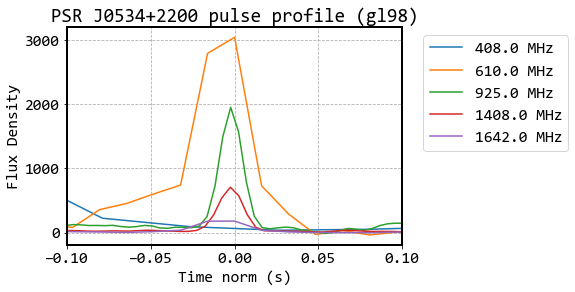

In [7]:
targetPSR = input("Select pulsar target (J-name): ") #"J0534+2200"
for reference in epndict[targetPSR]:
    print(f"There are {len(epndict[targetPSR][reference])} datafiles available from {reference}.")
targetref = input("Select the source publication from which to plot data: ")

for filename in epndict[targetPSR][targetref]:
    pointer = "/".join(["http://www.epta.eu.org/epndb/json",targetref,targetPSR,filename])
    data = json.loads(requests.get(pointer).content)
    series = np.array(data["series"]["I"]).T
    plt.plot(series[0],series[1],label=str(round(float(data["hdr"]["freq"]),0))+" MHz")

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlim((-0.1,0.1))
plt.xlabel("Time norm (s)")
plt.ylabel("Flux Density")
plt.title(f"PSR {targetPSR} pulse profile ({targetref})")
plt.grid(linestyle="--")
plt.show()

### Glitch catalog from the [Jodrell Bank Centre for Astrophysics](http://www.jb.man.ac.uk/pulsar/glitches.html)
Contains information about glitching (but not necessarily nulling) pulsars.

In [8]:
glitches = pd.read_html("http://www.jb.man.ac.uk/pulsar/glitches/gTable.html",header=3)[0].drop("Unnamed: 0",axis=1).drop([0]+list(range(556,572)),axis=0)
glitches.rename(columns={"No.":"Glitches","+/-":"MJD_e","dF/F":"dP0/P0","+/-.1":"dP0/P0_e","dF1/F1":"dP1/P1","+/-.2":"dP1/P1_e"},inplace=True)

In [9]:
numeric_cols=["Glitches","MJD","MJD_e","dP0/P0","dP0/P0_e","dP1/P1","dP1/P1_e"]
glitches[numeric_cols] = glitches[numeric_cols].apply(pd.to_numeric, errors='coerce')
glitches[["dP0/P0","dP0/P0_e"]] *= 1e-9
glitches[["dP1/P1","dP1/P1_e"]] *= 1e-3
glitches["J-name"] = ["J"+name if name[0] is not "J" else name for name in glitches["J-name"].values ]
dates = Time(glitches["MJD"],format="mjd")
glitches["ISO Date"] = dates.iso

glitchstats = pd.merge(merged,glitches,left_on="PSRJ",right_on="J-name").loc[:,["PSRJ","Glitches","P0","P1","NF","NF_e","dP0/P0","dP0/P0_e","dP1/P1","dP1/P1_e"]]

### Relationships of various pulsar parameters to nulling fraction
Multiplot comparing period, magnetic field, age, and energy loss rate to nulling fraction.

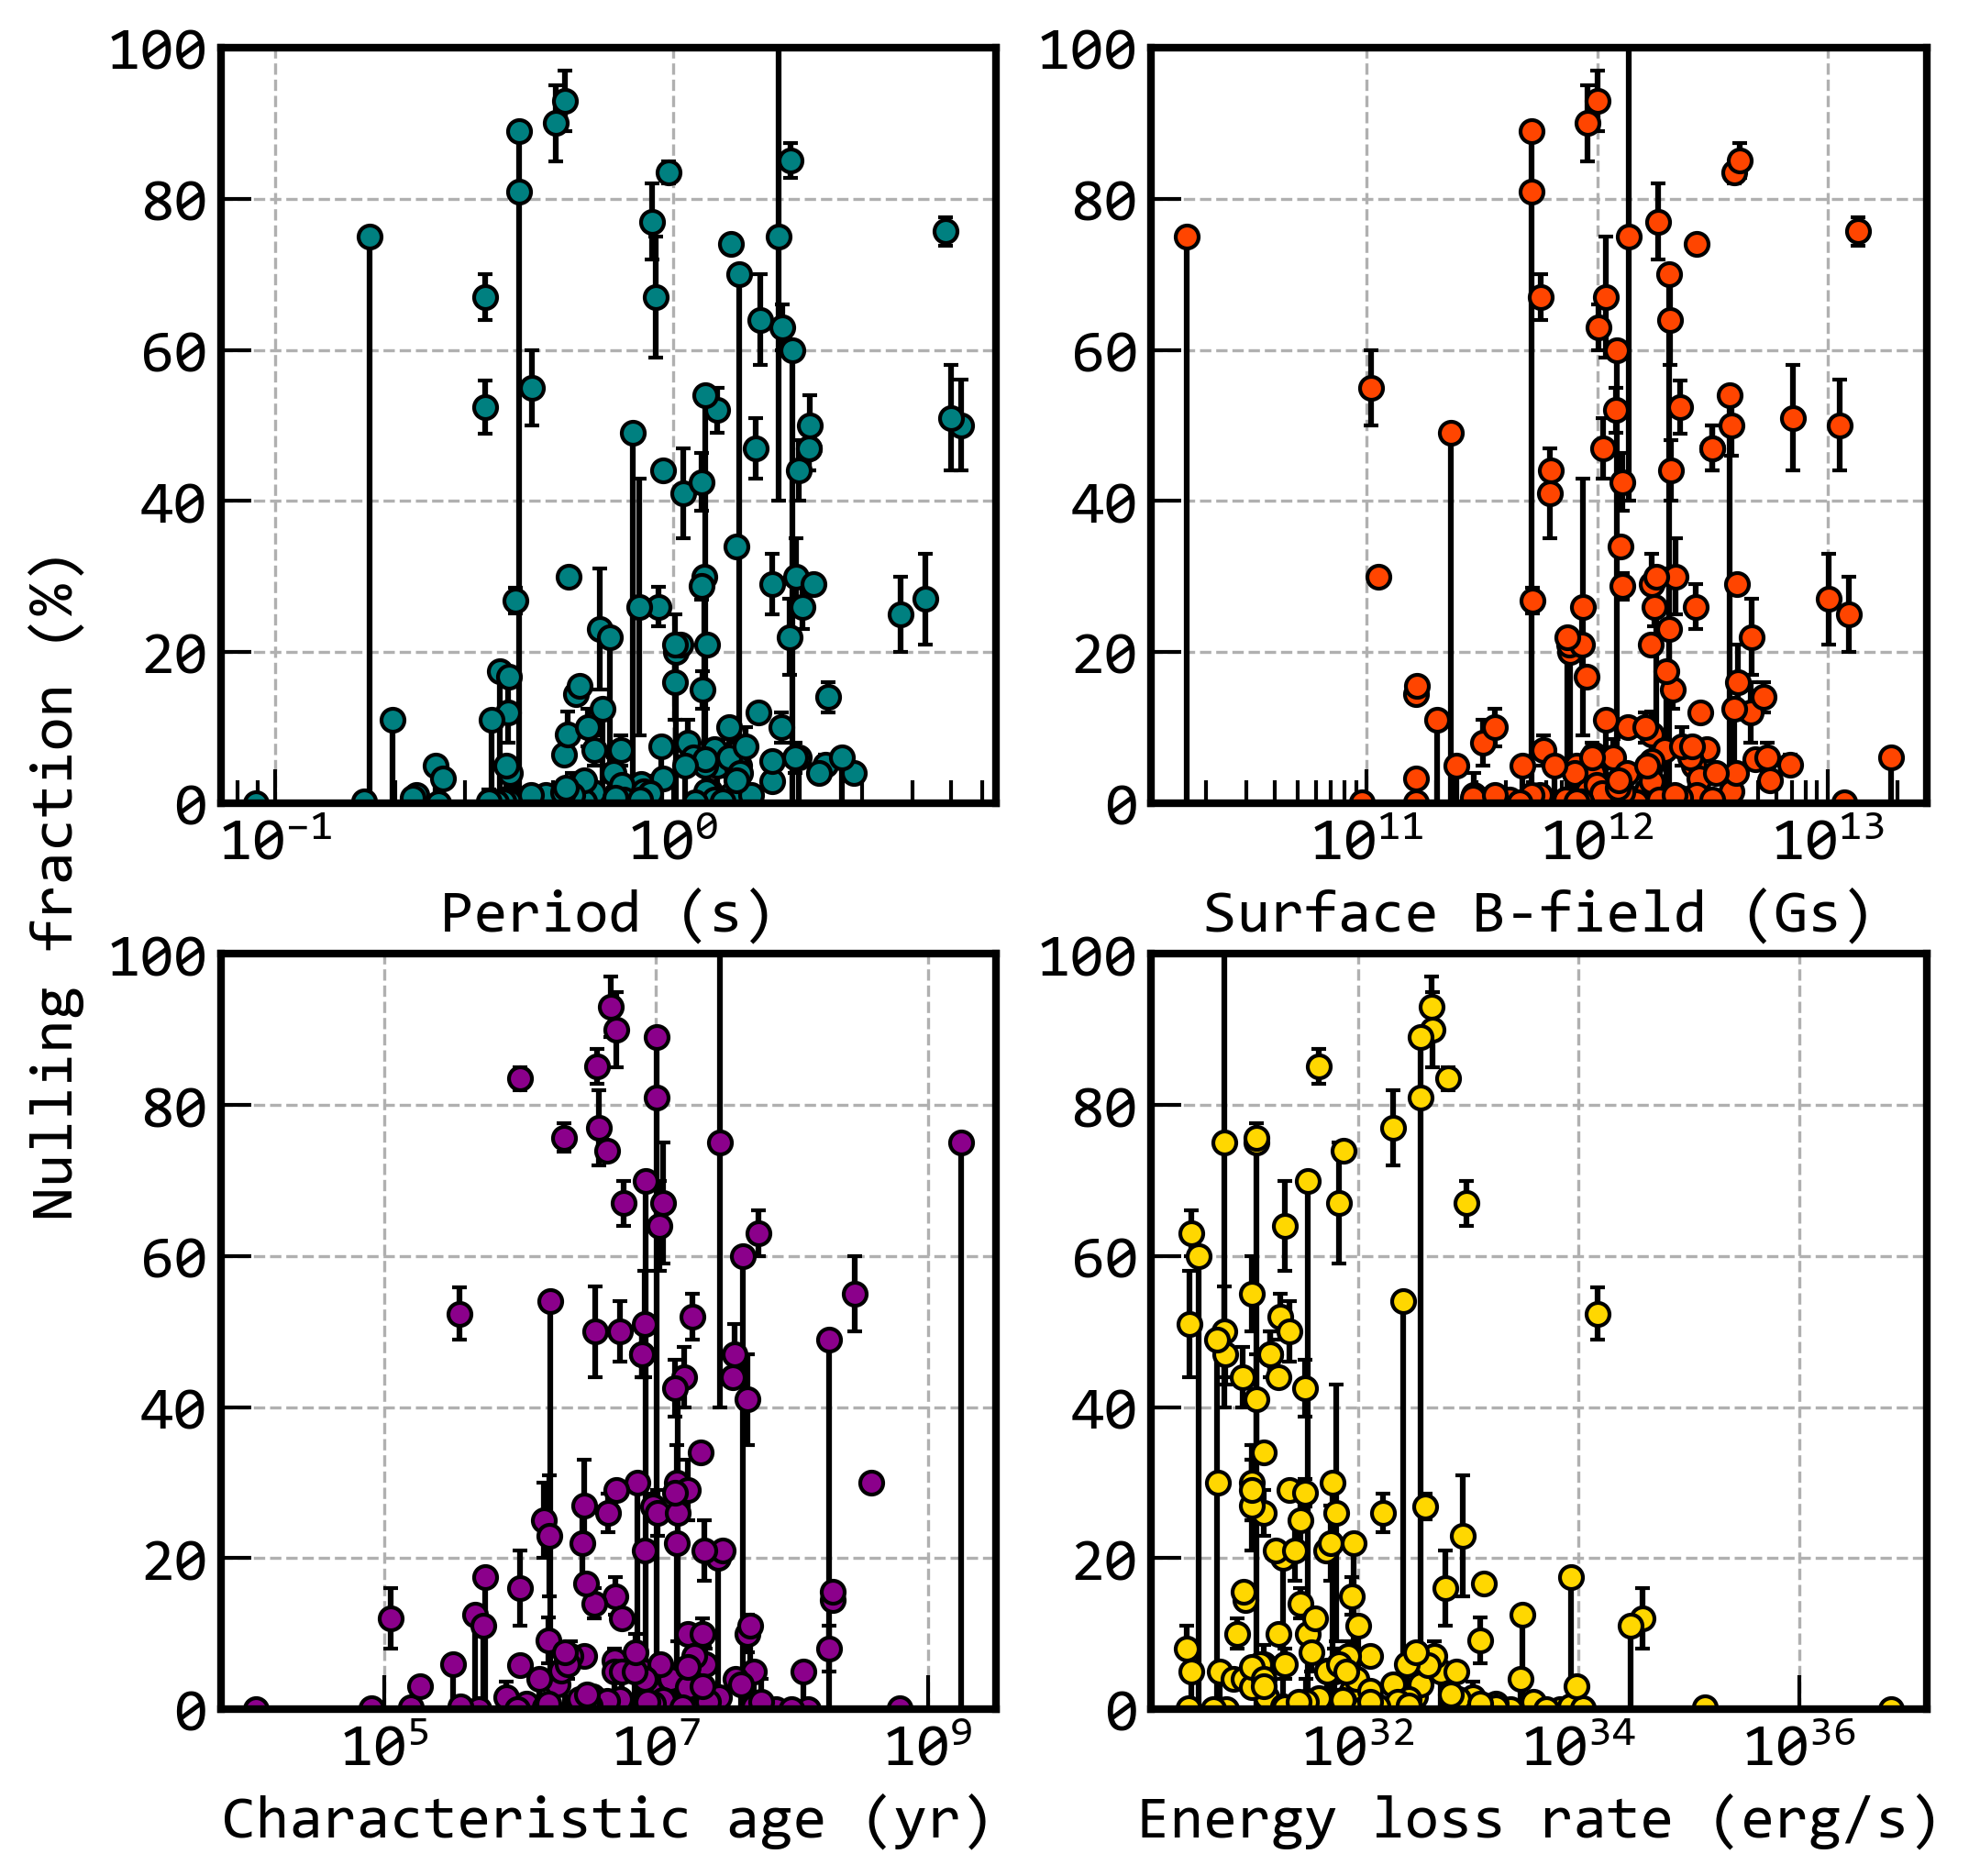

In [10]:
fig = plt.figure(figsize=(8,8),dpi=300)
fig.tight_layout()
axes = [fig.add_subplot(arrangement) for arrangement in [221,222,223,224]]

xvars = ["P0","BSURF","AGE","EDOT"]
labels = dict(zip(xvars,["Period (s)","Surface B-field (Gs)","Characteristic age (yr)","Energy loss rate (erg/s)"]))
colors = dict(zip(xvars,["teal","orangered","darkmagenta","gold"]))

NF_errors = np.array(list(merged["NF_e"])).T


for ax,xvar in zip(axes,xvars):
    ax.errorbar(merged[xvar],merged["NF"],yerr=NF_errors,fmt="o",ecolor="k",capsize=2,mfc=colors[xvar],mec="k")
    ax.set_xscale("log")
    ax.set_xlabel(labels[xvar])

    ax.set_ylim((0,100))
    ax.xaxis.set_tick_params(which='major', size=9, width=1, direction='in')
    ax.xaxis.set_tick_params(which='minor', size=6, width=1, direction='in')
    ax.yaxis.set_tick_params(which='major', size=8, width=1, direction='in')
    ax.yaxis.set_tick_params(which='minor', size=6, width=1, direction='in')
    ax.grid(linestyle="--")

#fig.suptitle("Relationships of Various Pulsar Properties to NF")
fig.text(0.05,0.5, "Nulling fraction (%)", ha="center", va="center", rotation=90)

plt.show()

### $P$-$\dot{P}$ diagram
Entire ATNF catalog in grey, nulling pulsars (as called out in [2019JApA...40...42K](https://ui.adsabs.harvard.edu/#abs/2019JApA...40...42K/abstract)) in green.

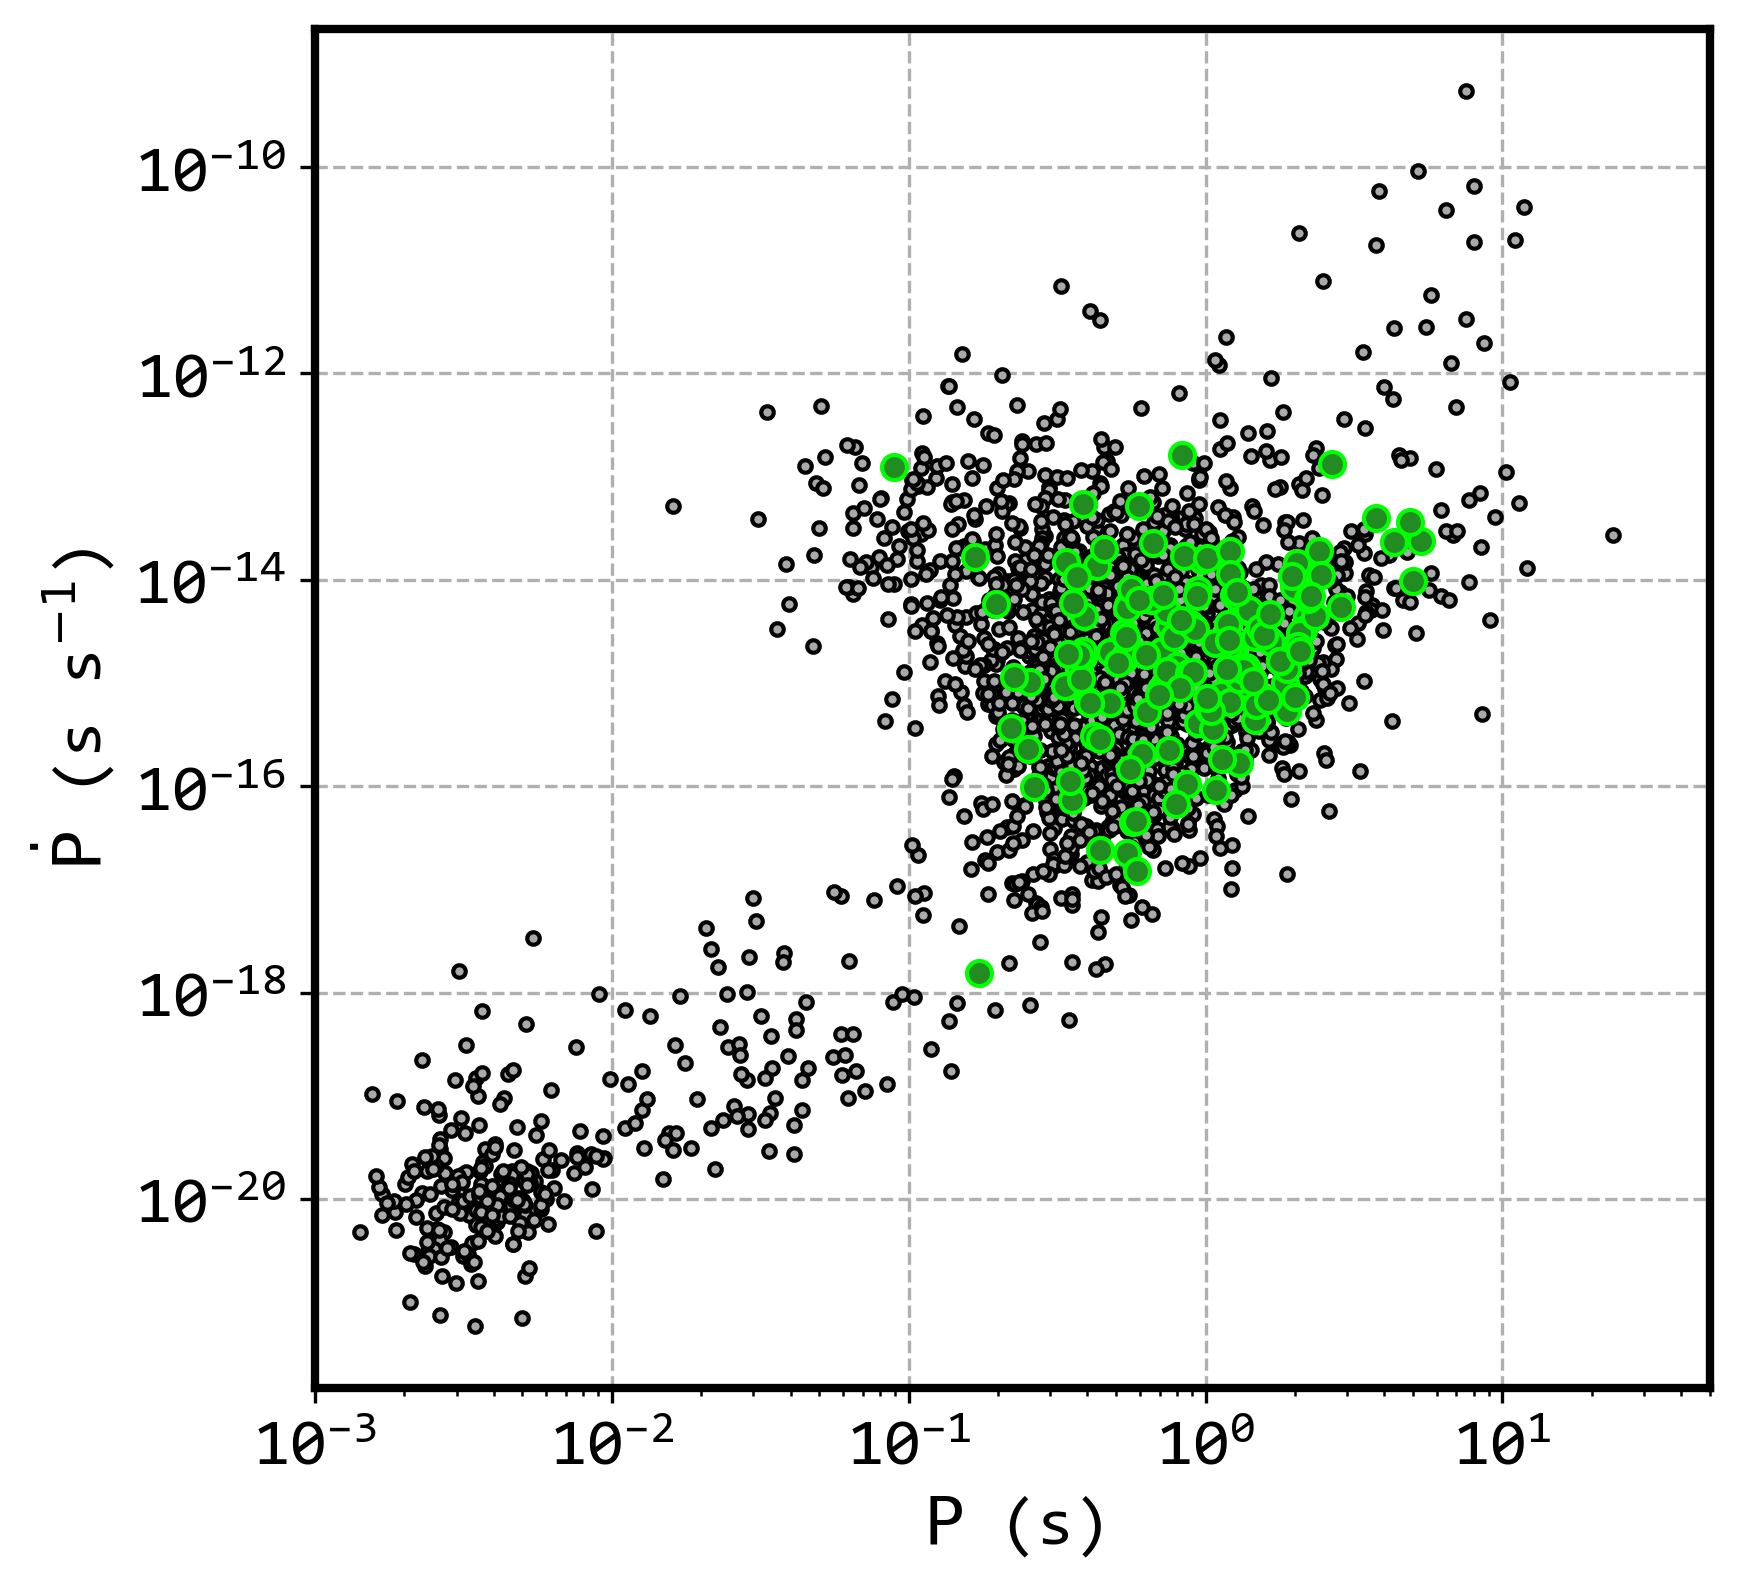

In [11]:
fig, ax = plt.subplots(figsize=(6,6),dpi=300)

plt.loglog(ATNF.P0,ATNF.P1,".",mfc="darkgrey",mec="k")
plt.loglog(merged.P0,merged.P1,"o",mfc="forestgreen",mec="lime")
plt.xlabel("$\mathrm{P}$ (s)")
plt.ylabel("$\dot{\mathrm{P}}$ (s s$^{-1}$)")
plt.grid(linestyle="--")
plt.xlim((1e-3,.5e2))

plt.show()

### Nulling fraction as a function of period and magnetic field
Clustering towards shorter periods, weaker magnetic fields, and lower nulling fractions can be readily observed.

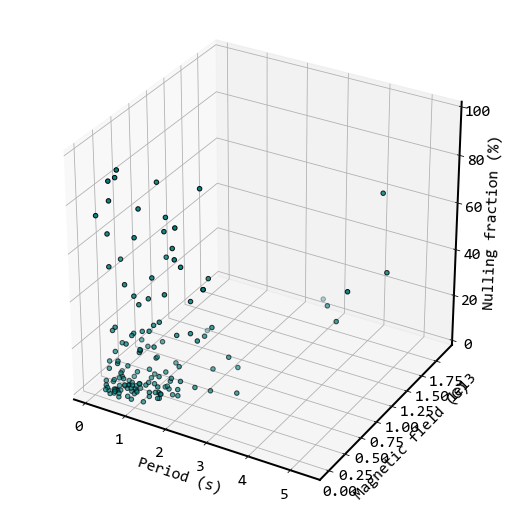

In [12]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0,0,1,1],projection='3d')

ax.scatter(merged.P0,merged.BSURF,merged.NF,color="teal",edgecolor="black")
ax.set_xlabel("Period (s)")
ax.set_ylabel("Magnetic field (G)")
ax.set_zlabel("Nulling fraction (%)")

ax.set_zlim3d(0, 100)

plt.show()

### Locations of observed nulling pulsars in the sky (galactic coords)
Plots the galactic latitude and longitude on a Aitoff projection skymap. Color represents age and size represents distance.

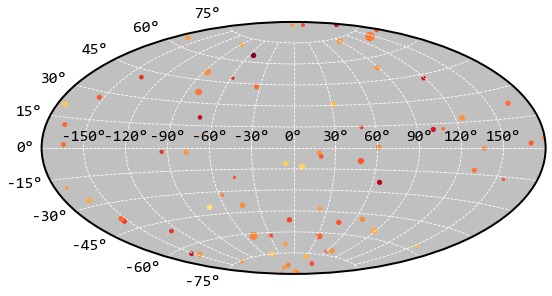

In [13]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0,0,1,1],projection='aitoff')
ax.scatter(merged.Gl,merged.Gb,s=10*np.sqrt(merged.DIST[::-1]),c=np.log10(merged.AGE),cmap="YlOrRd")
ax.set_facecolor("silver")
ax.grid(linestyle="--",color="white")

plt.show()

### Locations of observed nulling pulsars in the galactic plane
Using the X and Y coords given in the galactic disc reference frame, the locations of the nulling pulsars can be superimposed on an image of the galaxy. The fact that we are less likely to observe pulsars on the other side of the galactic core is obvious here.

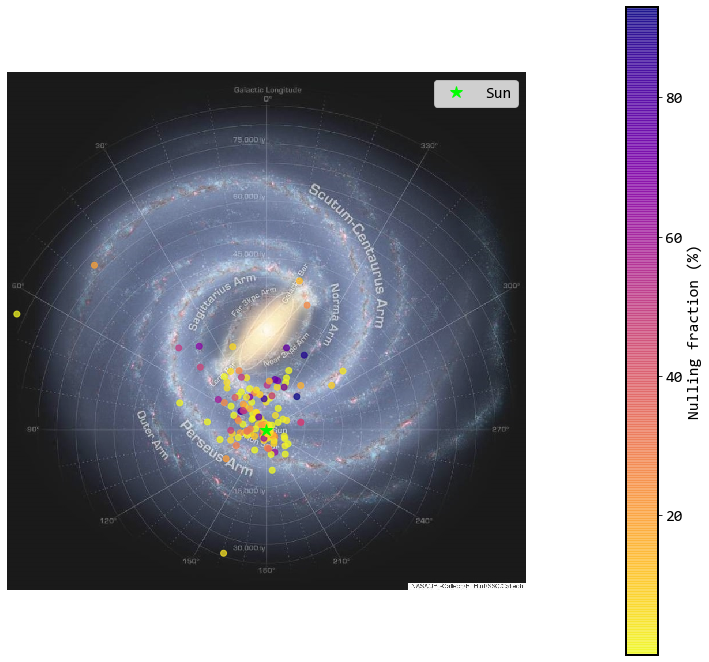

In [14]:
polarfig = plt.figure(figsize=(9,9))
aximage = polarfig.add_axes([0,0,0.8,1],zorder=-1)
axplot = polarfig.add_axes([0,0,1,1],projection='polar',zorder=1)

galaxy = plt.imread("milkymap.jpg")
aximage.imshow(galaxy,alpha=.9)
aximage.axis('off')

theta = np.array([(np.arctan(y/x) if x > 0 else np.arctan(y/x)+np.pi if x<0 else y/np.abs(y) * np.pi/2) for x,y in zip(merged.XX,merged.YY)])+np.pi
r = np.sqrt(merged.XX**2+merged.YY**2)
colordists = [(-np.nan if Z < -2.5 else np.nan if Z > 2.5 else Z) for Z in merged.ZZ]

polarplot = axplot.scatter(theta,r,c=merged.NF,marker="o",cmap="plasma_r",alpha=0.75)
sunpoint = axplot.plot(-np.pi/2,8.2,marker="*",markersize=12,linestyle="",color="lime",label="Sun")
axplot.set_facecolor('none')
axplot.set_rlim((0,21.5))
axplot.set_xticklabels([])
axplot.set_ylabel("Distance (kpc)")
axplot.axis('off')
axplot.legend()
polarfig.colorbar(polarplot,anchor=(1.05,0.0),label="Nulling fraction (%)")
plt.show()

### Radial distribution of nulling vs. non-nulling pulsars
Demonstration of the fact that there is no apparent difference in the distribution of distances of nulling pulsars vs. non-nulling pulsars.

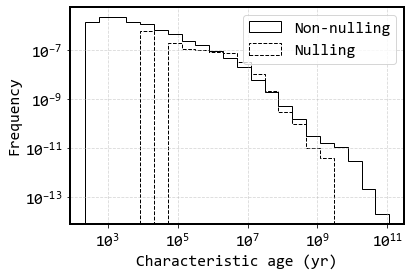

In [15]:
mainX = ATNF.loc[(idx for idx in ATNF.index if ATNF.loc[idx,"PSRJ"] not in merged["PSRJ"]),"AGE"].dropna()
hist, bins = np.histogram(mainX, bins=22)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))


mainX.plot.hist(density=True,bins=logbins,histtype="step",ls="-",lw=1,color="k",label="Non-nulling")

merged.AGE.plot.hist(density=True,bins=logbins,histtype="step",ls="--",lw=1,color="k",label="Nulling")
#plt.xlim((100,1e11))
plt.grid(linestyle="--",alpha=0.5)
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Characteristic age (yr)")
plt.show()